In [1]:
# Suppressing Warnings
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline 

import seaborn as sns
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)


import string
import math
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from keras.preprocessing.text import Tokenizer
from keras.layers import Input, Dropout, Dense, BatchNormalization, Activation, concatenate, GRU, LSTM, Embedding, Flatten, BatchNormalization
from keras.models import Model
from keras import backend as K
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [2]:
products_data = pd.read_csv('Dataset/Intermediate/all_products.csv')
products_data.head()

,product_name,brand_name,product_category,description,product_category_wide,mrp,price,%discount
0,"""I DO"" Signature Lace Cheeky Hipster with Gift...",hanky panky,Collections,"With ""I DO"" emblazoned on this Hanky Panky lac...",panties,40.0,40.0,0.0
1,"""I DO"" Signature Lace Cheeky Hipster with Gift...",hanky panky,Panties,"With ""I DO"" emblazoned on this Hanky Panky lac...",panties,40.0,40.0,0.0
2,'After Midnight' Lace Open Gusset G-String,hanky panky,Bridal Lingerie,Stretch signature lace fashions an alluring do...,other,27.0,27.0,0.0
3,'After Midnight' Lace Open Gusset G-String,hanky panky,Sexy Lingerie,Stretch signature lace fashions an alluring do...,other,27.0,27.0,0.0
4,'After Midnight' Lace Open Gusset G-String,hanky panky,Women's Panties,Stretch signature lace fashions an alluring do...,other,27.0,27.0,0.0


In [3]:
products_data['description'] = products_data['description'].str.lower()
products_data['product_name'] = products_data['product_name'].str.lower()
products_data.head()

,product_name,brand_name,product_category,description,product_category_wide,mrp,price,%discount
0,"""i do"" signature lace cheeky hipster with gift...",hanky panky,Collections,"with ""i do"" emblazoned on this hanky panky lac...",panties,40.0,40.0,0.0
1,"""i do"" signature lace cheeky hipster with gift...",hanky panky,Panties,"with ""i do"" emblazoned on this hanky panky lac...",panties,40.0,40.0,0.0
2,'after midnight' lace open gusset g-string,hanky panky,Bridal Lingerie,stretch signature lace fashions an alluring do...,other,27.0,27.0,0.0
3,'after midnight' lace open gusset g-string,hanky panky,Sexy Lingerie,stretch signature lace fashions an alluring do...,other,27.0,27.0,0.0
4,'after midnight' lace open gusset g-string,hanky panky,Women's Panties,stretch signature lace fashions an alluring do...,other,27.0,27.0,0.0


In [4]:
products_data.shape

(5982, 8)

In [5]:
products_data = products_data[['product_name', 'brand_name', 'product_category_wide', 'description', 'mrp']]
products_data.drop_duplicates(inplace = True)
print(products_data.shape)
products_data.head()

(3446, 5)


,product_name,brand_name,product_category_wide,description,mrp
0,"""i do"" signature lace cheeky hipster with gift...",hanky panky,panties,"with ""i do"" emblazoned on this hanky panky lac...",40.0
2,'after midnight' lace open gusset g-string,hanky panky,other,stretch signature lace fashions an alluring do...,27.0
5,'after midnight' open gusset lace thong,hanky panky,panties,leopard-spotted lace adds to the bold open-gus...,24.0
8,'annabelle' lace camisole,hanky panky,camisoles,scalloped trim adorned with a little blue bow ...,64.0
9,'annabelle' lace garter,hanky panky,other,scalloped lace adorned with a little blue bow ...,23.0


In [6]:
# Stopwords removal
stopwords = [ "a", "about", "above", "after", "again", "against", "all", "am", "an", "and", "any", "are", "as", "at", "be", "because", 
             "been", "before", "being", "below", "between", "both", "but", "by", "could", "did", "do", "does", "doing", "down", "during",
             "each", "few", "for", "from", "further", "had", "has", "have", "having", "he", "he'd", "he'll", "he's", "her", "here", 
             "here's", "hers", "herself", "him", "himself", "his", "how", "how's", "i", "i'd", "i'll", "i'm", "i've", "if", "in", "into",
             "is", "it", "it's", "its", "itself", "let's", "me", "more", "most", "my", "myself", "nor", "of", "on", "once", "only", "or",
             "other", "ought", "our", "ours", "ourselves", "out", "over", "own", "same", "she", "she'd", "she'll", "she's", "should", 
             "so", "some", "such", "than", "that", "that's", "the", "their", "theirs", "them", "themselves", "then", "there", "there's",
             "these", "they", "they'd", "they'll", "they're", "they've", "this", "those", "through", "to", "too", "under", "until", "up",
             "very", "was", "we", "we'd", "we'll", "we're", "we've", "were", "what", "what's", "when", "when's", "where", "where's",
             "which", "while", "who", "who's", "whom", "why", "why's", "with", "would", "you", "you'd", "you'll", "you're", "you've",
             "your", "yours", "yourself", "yourselves"]

In [7]:
le = LabelEncoder()

le.fit(np.hstack([products_data.product_category_wide]))
products_data.product_category_wide = le.transform(products_data.product_category_wide)

le.fit(np.hstack([products_data.brand_name]))
products_data.brand_name = le.transform(products_data.brand_name)
del le

products_data.head()

,product_name,brand_name,product_category_wide,description,mrp
0,"""i do"" signature lace cheeky hipster with gift...",6,7,"with ""i do"" emblazoned on this hanky panky lac...",40.0
2,'after midnight' lace open gusset g-string,6,6,stretch signature lace fashions an alluring do...,27.0
5,'after midnight' open gusset lace thong,6,7,leopard-spotted lace adds to the bold open-gus...,24.0
8,'annabelle' lace camisole,6,5,scalloped trim adorned with a little blue bow ...,64.0
9,'annabelle' lace garter,6,6,scalloped lace adorned with a little blue bow ...,23.0


In [8]:
def remove_stopwords(data):
  data['clean_description'] = data['description'].apply(lambda x : ' '.join([word for word in x.split() if word not in (stopwords)]))
  return data

data_cleaned = remove_stopwords(products_data)
data_cleaned['clean_description'] = data_cleaned['clean_description'].str.replace('[{}]'.format(string.punctuation), ' ')
data_cleaned.drop('description', inplace = True, axis = 1)
data_cleaned.head()

,product_name,brand_name,product_category_wide,mrp,clean_description
0,"""i do"" signature lace cheeky hipster with gift...",6,7,40.0,i do emblazoned hanky panky lace hipster swa...
2,'after midnight' lace open gusset g-string,6,6,27.0,stretch signature lace fashions alluring doubl...
5,'after midnight' open gusset lace thong,6,7,24.0,leopard spotted lace adds bold open gusset des...
8,'annabelle' lace camisole,6,5,64.0,scalloped trim adorned little blue bow flirts ...
9,'annabelle' lace garter,6,6,23.0,scalloped lace adorned little blue bow defines...


In [9]:
# Tokenizing
raw_text = np.hstack([data_cleaned.clean_description.str.lower(), data_cleaned.product_name.str.lower()])
tok_raw = Tokenizer()
tok_raw.fit_on_texts(raw_text)
data_cleaned["seq_description"] = tok_raw.texts_to_sequences(data_cleaned.clean_description.str.lower())
data_cleaned["seq_product_name"] = tok_raw.texts_to_sequences(data_cleaned.product_name.str.lower())
max_seq_description = np.max(data_cleaned.seq_description.apply(lambda x: len(x)))
max_seq_product_name = np.max(data_cleaned.seq_product_name.apply(lambda x: len(x)))
print("Maximum Value of Sequences: ", max_seq_description, max_seq_product_name)

MAX_TEXT = np.max([np.max(data_cleaned.seq_description.apply(lambda x : max(x))),
                   np.max(data_cleaned.seq_product_name.apply(lambda x : max(x)))])  + 3

MAX_BRAND = np.max(data_cleaned.brand_name.max()) + 3
MAX_CAT = np.max(data_cleaned.product_category_wide.max()) + 3

data_cleaned.head()

Maximum Value of Sequences:  91 12


,product_name,brand_name,product_category_wide,mrp,clean_description,seq_description,seq_product_name
0,"""i do"" signature lace cheeky hipster with gift...",6,7,40.0,i do emblazoned hanky panky lace hipster swa...,"[540, 541, 1760, 83, 90, 1, 98, 1201, 557, 296...","[540, 541, 70, 1, 175, 98, 283, 439, 561]"
2,'after midnight' lace open gusset g-string,6,6,27.0,stretch signature lace fashions alluring doubl...,"[34, 70, 1, 1035, 612, 542, 174, 415, 246, 109...","[2569, 2570, 1, 211, 397, 415, 246]"
5,'after midnight' open gusset lace thong,6,7,24.0,leopard spotted lace adds bold open gusset des...,"[182, 691, 1, 416, 724, 211, 397, 135, 644, 49...","[2569, 2570, 211, 397, 1, 8]"
8,'annabelle' lace camisole,6,5,64.0,scalloped trim adorned little blue bow flirts ...,"[302, 75, 1406, 340, 285, 156, 2620, 521, 77, ...","[2571, 1, 426]"
9,'annabelle' lace garter,6,6,23.0,scalloped lace adorned little blue bow defines...,"[302, 1, 1406, 340, 285, 156, 1990, 1407, 1109...","[2571, 1, 288]"


array([[<AxesSubplot:title={'center':'target'}>]], dtype=object)

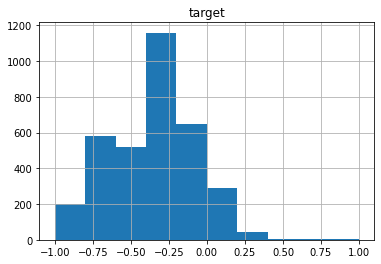

In [10]:
# Min Max Scaler for target
data_cleaned["target"] = np.log(data_cleaned.mrp+1)
target_scaler = MinMaxScaler(feature_range=(-1, 1))
data_cleaned["target"] = target_scaler.fit_transform(data_cleaned.target.values.reshape(-1,1))
pd.DataFrame(data_cleaned.target).hist()

In [11]:
# Train Test Split
dtrain, dtest = train_test_split(data_cleaned, random_state=123, train_size=0.90)
print(dtrain.shape)
print(dtest.shape)
dtrain.head()

(3101, 8)
(345, 8)


,product_name,brand_name,product_category_wide,mrp,clean_description,seq_description,seq_product_name,target
4479,seamless hipster briefs,9,7,13.00,ultrasoft stretchy microfiber shapes comforta...,"[1688, 49, 389, 694, 95, 98, 208, 1933, 303, 3...","[48, 98, 208]",-0.690375
2199,bridget pushup cotton bra,0,4,32.95,flirt everyday perkiness every girl style 97...,"[569, 73, 630, 89, 159, 5, 1070, 1639, 9, 933,...","[643, 66, 7, 2]",-0.294680
843,aerie everyday loves lace thong,0,7,12.50,introducing everyday loves™ made love everyd...,"[356, 73, 357, 32, 39, 73, 116, 258, 234, 140,...","[14, 73, 116, 1, 8]",-0.706620
324,aerie bikini,0,6,9.50,peek cheek lot wow soft comfy cotton love fi...,"[27, 26, 230, 207, 18, 20, 7, 39, 23, 65, 87, ...","[14, 38]",-0.818881
3247,id logo mesh-panel hipster qf1780,2,7,22.00,kick style notch logo enhanced cooling hipster...,"[1690, 5, 2943, 35, 701, 1889, 98, 54, 59]","[406, 35, 36, 364, 98, 3654]",-0.468620


In [12]:
# Sequence Padding
def get_keras_data(dataset):
    X = {
        'item_name':  pad_sequences(dataset.seq_product_name, maxlen=10),
        'item_desc': pad_sequences(dataset.seq_description, maxlen=75),
        'brand_name': np.array(dataset.brand_name),
        'product_category': np.array(dataset.product_category_wide)
    }
    return X

X_train = get_keras_data(dtrain)
X_test = get_keras_data(dtest)
X_train

{'item_name': array([[   0,    0,    0, ...,   48,   98,  208],
        [   0,    0,    0, ...,   66,    7,    2],
        [   0,    0,    0, ...,  116,    1,    8],
        ...,
        [   0,  165,  133, ...,  288,  452, 3534],
        [   0,    0,    0, ...,  833,   19, 3582],
        [   0,    0,    0, ...,  118,  132,    2]]),
 'item_desc': array([[   0,    0,    0, ...,   62,  304,   23],
        [   0,    0,    0, ...,    3,    3,   11],
        [   0,    0,    0, ...,    3,    3,   11],
        ...,
        [   0,    0,    0, ...,  133,   54,   59],
        [   0,    0,    0, ...,  238,  243,  135],
        [   0,    0,    0, ...,  264,  837, 1243]]),
 'brand_name': array([9, 0, 0, ..., 2, 6, 2]),
 'product_category': array([ 7,  4,  7, ..., 12,  3,  4])}

## GRU Based Model

In [13]:
# Model Training
def rmsle_cust(y_true, y_pred):
    first_log = K.log(K.clip(y_pred, K.epsilon(), None) + 1.)
    second_log = K.log(K.clip(y_true, K.epsilon(), None) + 1.)
    return K.sqrt(K.mean(K.square(first_log - second_log), axis=-1))

def get_gru_model():
    # Params
    dr_r = 0.1
    
    # Inputs
    item_name = Input(shape=[X_train["item_name"].shape[1]], name="item_name")
    item_desc = Input(shape=[X_train["item_desc"].shape[1]], name="item_desc")
    brand_name = Input(shape=[1], name="brand_name")
    product_category = Input(shape=[1], name="product_category")
    
    # Embeddings Layers
    emb_item_name = Embedding(MAX_TEXT, 50)(item_name)
    emb_item_desc = Embedding(MAX_TEXT, 50)(item_desc)
    emb_brand_name = Embedding(MAX_BRAND, 10)(brand_name)
    emb_product_category = Embedding(MAX_CAT, 10)(product_category)
    
    # RNN Layer
    rnn_layer1 = GRU(16) (emb_item_desc)
    rnn_layer2 = GRU(8) (emb_item_name)
    
    # Main Layer
    main_l = concatenate([
        rnn_layer1,
        rnn_layer2,
        Flatten() (emb_brand_name)
        , Flatten() (emb_product_category)
    ])
    main_l = Dropout(dr_r) (Dense(128) (main_l))
    main_l = Dropout(dr_r) (Dense(64) (main_l))
    
    # Output Layer
    output = Dense(1, activation="linear") (main_l)
    
    # Init Model
    model = Model([item_name, item_desc, brand_name, product_category], output)
    model.compile(loss="mse", optimizer="adam", metrics=["mae", rmsle_cust])
    
    return model

    
gru_model = get_gru_model()

# Calculation of Loss History
class LossHistory(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []

    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))

history = LossHistory()
gru_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 item_desc (InputLayer)         [(None, 75)]         0           []                               
                                                                                                  
 item_name (InputLayer)         [(None, 10)]         0           []                               
                                                                                                  
 brand_name (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 product_category (InputLayer)  [(None, 1)]          0           []                               
                                                                                              

In [14]:
# Model Fitting

BATCH_SIZE = 20000
epochs = 5
gru_model = get_gru_model()
gru_model.fit(X_train, dtrain.target, epochs=epochs, batch_size=BATCH_SIZE
          , validation_data=(X_test, dtest.target)
          , verbose=1, callbacks=[history])

Epoch 1/5
1/1 [==============================] - 3s 3s/step - loss: 0.1904 - mae: 0.3610 - rmsle_cust: 0.0139 - val_loss: 0.1431 - val_mae: 0.3025 - val_rmsle_cust: 0.0077
Epoch 2/5
1/1 [==============================] - 0s 199ms/step - loss: 0.1549 - mae: 0.3186 - rmsle_cust: 0.0102 - val_loss: 0.1148 - val_mae: 0.2673 - val_rmsle_cust: 0.0077
Epoch 3/5
1/1 [==============================] - 0s 219ms/step - loss: 0.1249 - mae: 0.2808 - rmsle_cust: 0.0101 - val_loss: 0.0916 - val_mae: 0.2365 - val_rmsle_cust: 0.0077
Epoch 4/5
1/1 [==============================] - 0s 195ms/step - loss: 0.0998 - mae: 0.2482 - rmsle_cust: 0.0101 - val_loss: 0.0741 - val_mae: 0.2129 - val_rmsle_cust: 0.0077
Epoch 5/5
1/1 [==============================] - 0s 208ms/step - loss: 0.0807 - mae: 0.2240 - rmsle_cust: 0.0101 - val_loss: 0.0633 - val_mae: 0.2013 - val_rmsle_cust: 0.0077


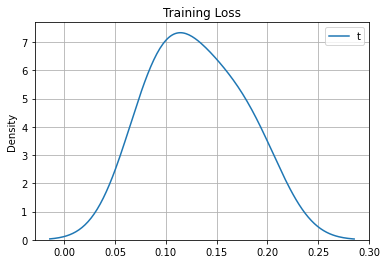

In [15]:
loss_range=np.log(history.losses)
sns.distplot(history.losses, hist=False)
plt.title('Training Loss')
plt.grid()
plt.legend('top')
plt.show()

In [16]:
def rmsle(y, y_pred):
    assert len(y) == len(y_pred)
    to_sum = [(math.log(y_pred[i] + 1) - math.log(y[i] + 1)) ** 2.0 for i,pred in enumerate(y_pred)]
    return (sum(to_sum) * (1.0/len(y))) ** 0.5

val_preds = gru_model.predict(X_test)
val_preds = target_scaler.inverse_transform(val_preds)
val_preds = np.exp(val_preds)+1

# mean_absolute_error, mean_squared_log_error.
y_true = np.array(dtest.mrp.values)
y_pred = val_preds[:,0]
v_rmsle = rmsle(y_true, y_pred)
v_rmse = mean_squared_error(y_true, y_pred , squared=False)
print(" RMSLE error on dev test: "+str(v_rmsle))
print(" RMSE error on dev test: "+str(v_rmse))

11/11 [==============================] - 0s 3ms/step
 RMSLE error on dev test: 0.5750002143399544
 RMSE error on dev test: 19.50839617498557


In [17]:
# Predict the price.
preds = gru_model.predict(X_test, batch_size=BATCH_SIZE)
preds = target_scaler.inverse_transform(preds)
preds = np.exp(preds)-1
dtest["predicted_price"] = preds
dtest.head()

1/1 [==============================] - 0s 24ms/step


,product_name,brand_name,product_category_wide,mrp,clean_description,seq_description,seq_product_name,target,predicted_price
3619,logo to go low rise thong 631581,6,7,22.00,soft sheer lace wraps around waist lightweigh...,"[18, 72, 1, 1261, 521, 161, 264, 20, 8, 83, 90]","[35, 87, 65, 21, 16, 8, 1980]",-0.468620,31.824623
3444,lace plunge bra,12,4,35.00,elegant black plunge bra prettified gorgeous l...,"[488, 133, 80, 2, 2973, 238, 1, 711, 109, 324,...","[1, 80, 2]",-0.268490,33.853363
2517,classic mesh triangle bralette,6,3,54.00,classic silhouettes airy stretch mesh,"[100, 682, 616, 34, 36]","[100, 36, 68, 19]",-0.079174,39.754723
3076,happy unlined bandeau bra,0,4,26.95,hello happy bras happiness feeling like real...,"[240, 52, 92, 148, 269, 150, 12, 235, 360, 52,...","[52, 169, 312, 2]",-0.381549,27.177296
5635,b.provocative contrast-lace bra 951222,1,4,40.00,flattering sheer nude panels decorated intrica...,"[215, 72, 393, 781, 999, 571, 1250, 325, 3311,...","[67, 686, 216, 1, 2, 3892]",-0.210396,31.061394


## LSTM Based Model

In [18]:
def get_lstm_model():
    # Params
    dr_r = 0.1
    
    # Inputs
    item_name = Input(shape=[X_train["item_name"].shape[1]], name="item_name")
    item_desc = Input(shape=[X_train["item_desc"].shape[1]], name="item_desc")
    brand_name = Input(shape=[1], name="brand_name")
    product_category = Input(shape=[1], name="product_category")
    
    # Embeddings Layers
    emb_item_name = Embedding(MAX_TEXT, 50)(item_name)
    emb_item_desc = Embedding(MAX_TEXT, 50)(item_desc)
    emb_brand_name = Embedding(MAX_BRAND, 10)(brand_name)
    emb_product_category = Embedding(MAX_CAT, 10)(product_category)
    
    # RNN Layer
    rnn_layer1 = LSTM(16) (emb_item_desc)
    rnn_layer2 = LSTM(8) (emb_item_name)
    
    # Main Layer
    main_l = concatenate([
        rnn_layer1,
        rnn_layer2,
        Flatten() (emb_brand_name)
        , Flatten() (emb_product_category)
    ])
    main_l = Dropout(dr_r) (Dense(128) (main_l))
    main_l = Dropout(dr_r) (Dense(64) (main_l))
    
    # Output Layer
    output = Dense(1, activation="linear") (main_l)
    
    # Init Model
    model = Model([item_name, item_desc, brand_name, product_category], output)
    model.compile(loss="mse", optimizer="adam", metrics=["mae", rmsle_cust])
    
    return model

    
lstm_model = get_lstm_model()
history = LossHistory()
lstm_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 item_desc (InputLayer)         [(None, 75)]         0           []                               
                                                                                                  
 item_name (InputLayer)         [(None, 10)]         0           []                               
                                                                                                  
 brand_name (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 product_category (InputLayer)  [(None, 1)]          0           []                               
                                                                                            

In [19]:
lstm_model = get_lstm_model()
lstm_model.fit(X_train, dtrain.target, epochs=epochs, batch_size=BATCH_SIZE
          , validation_data=(X_test, dtest.target)
          , verbose=1, callbacks=[history])

Epoch 1/5
1/1 [==============================] - 3s 3s/step - loss: 0.2081 - mae: 0.3845 - rmsle_cust: 0.0246 - val_loss: 0.1574 - val_mae: 0.3224 - val_rmsle_cust: 0.0077
Epoch 2/5
1/1 [==============================] - 0s 231ms/step - loss: 0.1698 - mae: 0.3407 - rmsle_cust: 0.0102 - val_loss: 0.1262 - val_mae: 0.2833 - val_rmsle_cust: 0.0077
Epoch 3/5
1/1 [==============================] - 0s 229ms/step - loss: 0.1368 - mae: 0.2993 - rmsle_cust: 0.0101 - val_loss: 0.0995 - val_mae: 0.2481 - val_rmsle_cust: 0.0077
Epoch 4/5
1/1 [==============================] - 0s 222ms/step - loss: 0.1087 - mae: 0.2605 - rmsle_cust: 0.0101 - val_loss: 0.0778 - val_mae: 0.2163 - val_rmsle_cust: 0.0077
Epoch 5/5
1/1 [==============================] - 0s 242ms/step - loss: 0.0849 - mae: 0.2270 - rmsle_cust: 0.0101 - val_loss: 0.0623 - val_mae: 0.1942 - val_rmsle_cust: 0.0077


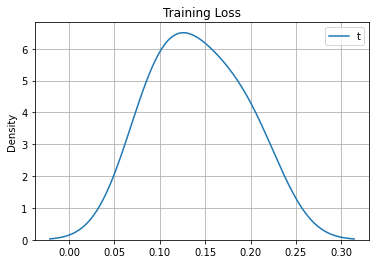

In [20]:
loss_range=np.log(history.losses)
sns.distplot(history.losses, hist=False)
plt.title('Training Loss')
plt.grid()
plt.legend('top')
plt.show()

In [21]:
val_preds = lstm_model.predict(X_test)
val_preds = target_scaler.inverse_transform(val_preds)
val_preds = np.exp(val_preds)+1

# mean_absolute_error, mean_squared_log_error.
y_true = np.array(dtest.mrp.values)
y_pred = val_preds[:,0]
v_rmsle = rmsle(y_true, y_pred)
v_rmse = mean_squared_error(y_true, y_pred , squared=False)
print(" RMSLE error on dev test: "+str(v_rmsle))
print(" RMSE error on dev test: "+str(v_rmse))

11/11 [==============================] - 0s 4ms/step
 RMSLE error on dev test: 0.5782232173553474
 RMSE error on dev test: 18.762964071571727


In [22]:
# Predict the price.
preds = lstm_model.predict(X_test, batch_size=BATCH_SIZE)
preds = target_scaler.inverse_transform(preds)
preds = np.exp(preds)-1
dtest["predicted_price"] = preds
dtest.head()

1/1 [==============================] - 0s 27ms/step


,product_name,brand_name,product_category_wide,mrp,clean_description,seq_description,seq_product_name,target,predicted_price
3619,logo to go low rise thong 631581,6,7,22.00,soft sheer lace wraps around waist lightweigh...,"[18, 72, 1, 1261, 521, 161, 264, 20, 8, 83, 90]","[35, 87, 65, 21, 16, 8, 1980]",-0.468620,39.222443
3444,lace plunge bra,12,4,35.00,elegant black plunge bra prettified gorgeous l...,"[488, 133, 80, 2, 2973, 238, 1, 711, 109, 324,...","[1, 80, 2]",-0.268490,35.381165
2517,classic mesh triangle bralette,6,3,54.00,classic silhouettes airy stretch mesh,"[100, 682, 616, 34, 36]","[100, 36, 68, 19]",-0.079174,38.946774
3076,happy unlined bandeau bra,0,4,26.95,hello happy bras happiness feeling like real...,"[240, 52, 92, 148, 269, 150, 12, 235, 360, 52,...","[52, 169, 312, 2]",-0.381549,33.452736
5635,b.provocative contrast-lace bra 951222,1,4,40.00,flattering sheer nude panels decorated intrica...,"[215, 72, 393, 781, 999, 571, 1250, 325, 3311,...","[67, 686, 216, 1, 2, 3892]",-0.210396,35.270103
